<a href="https://colab.research.google.com/github/RahulReadd/Computer_Vision_Projects-/blob/main/Panorama/Image_Stitching%26Panorama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings 
warnings.filterwarnings('ignore')

In [2]:
feature_extraction_algo = 'sift'

feature_to_match = 'bf'

In [3]:
train_photo = cv2.imread('/content/WhatsApp Image 2023-01-23 at 3.13.08 PM.jpeg')

train_photo = cv2.cvtColor(train_photo, cv2.COLOR_BGR2RGB)

train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('/content/WhatsApp Image 2023-01-23 at 3.13.09 PM.jpeg')

query_photo = cv2.cvtColor(query_photo, cv2.COLOR_BGR2RGB)

query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

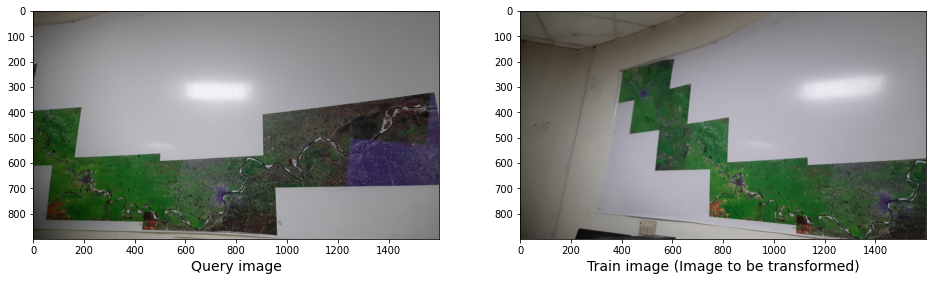

In [4]:
from matplotlib.colorbar import constrained_layout
#Ploting photos
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, constrained_layout = False,  figsize=(16,9))
ax1.imshow(query_photo, cmap = "gray")
ax1.set_xlabel("Query image", fontsize = 14)

ax2.imshow(train_photo, cmap = "gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize = 14)

plt.savefig("./_" + '.jpeg', bbox_inches = 'tight', dpi = 300, optimize = True, format = 'jpeg')

plt.show()

In [5]:
def select_descriptor_method(image, method = None):

  assert method is not None, "Please define a feature descriptor method. Accepted values are: 'sift', 'sruf', 'orb', 'brisk'"

  if method == 'sift': 
    descriptor = cv2.SIFT_create()
  elif method == 'surf':
    descriptor = cv2.SURF_create()
  elif method == 'orb':
    descriptor = cv2.ORB_create()
  elif method == 'brisk': 
    descriptor = cv2.BRISK_create()

  (keypoints, features) = descriptor.detectAndCompute(image,None)

  return (keypoints, features)

In [39]:
keypoints_train_img, Feature_train_img = select_descriptor_method(train_photo_gray, method = feature_extraction_algo)
keypoints_query_img, Feature_query_img = select_descriptor_method(query_photo_gray, method = feature_extraction_algo)

#print("Keypoints_query_img", keypoints_query_img)

In [7]:
for keypoint in keypoints_query_img: 
  x,y = keypoint.pt
  size = keypoint.size
  orientation = keypoint.angle 
  response = keypoint.response 
  octave = keypoint.octave 
  class_id = keypoint.class_id 

print(x,y) 
print(size) 
print(orientation) 
print(response)
print(octave)
print(class_id)

1595.1026611328125 409.4131774902344
2.424865961074829
348.5407409667969
0.01811712048947811
4981503
-1


In [8]:
len(keypoints_query_img)

3062

In [9]:
!mkdir output

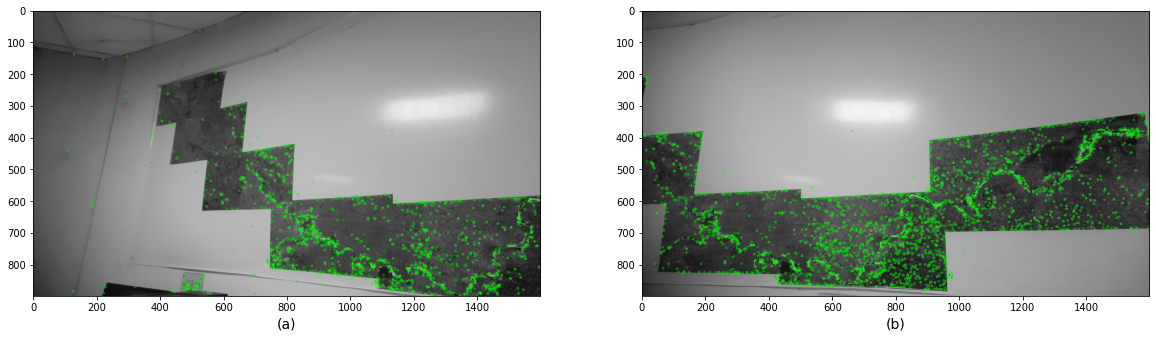

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8), constrained_layout = False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color = [0,255,0]))
ax1.set_xlabel("(a)", fontsize = 14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray, keypoints_query_img, None, color = [0,255,0]))
ax2.set_xlabel("(b)", fontsize = 14)

plt.savefig("./output/" + feature_extraction_algo + "_features_img" + ".jpeg", 
            bbox_inches='tight', dpi=300, optimize=True, format='jpeg')
plt.show()

In [11]:
 # Brute-force matcher 
def create_matching_object(method, crossCheck): 
  if method == 'sift' or method == 'surf': 
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = crossCheck)
  elif method == 'orb' or method == 'brisk':
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = crossCheck)

  return bf 

In [21]:
def Key_points_matching(feature_train_img, feature_query_img, method): 
  bf = create_matching_object(method, crossCheck = True)

  best_matches = bf.match(feature_train_img, feature_query_img)

  raw_matches = sorted(best_matches, key = lambda x: x.distance)
  print("Raw matches with Brute force):", len(raw_matches))

  return raw_matches

In [32]:
def key_points_matching_KNN (feature_train_img, feature_query_img, ratio, method): 
  bf = create_matching_object(method, crossCheck = False)
  
  raw_matches = bf.knnMatch(feature_train_img, feature_query_img, k = 2)
  print("Raw matches with (Knn)):", len(raw_matches))
  matches = []

    # loop over the raw matches
  for m,n in raw_matches:
       # ensure the distance is within a certain ratio of each
       # other (i.e. Lowe's ratio test)
       if m.distance < n.distance * ratio:
           matches.append(m)
  return matches

Drawing: {} matched features for  bf
Raw matches with Brute force): 852


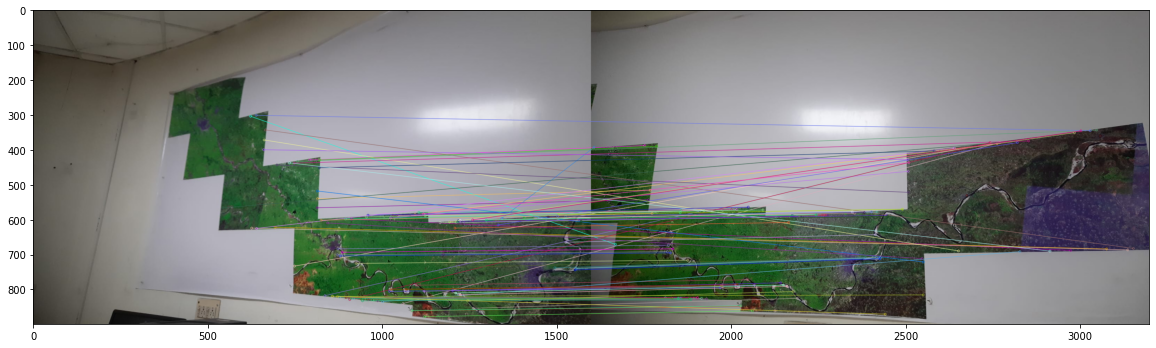

In [23]:
print("Drawing: {} matched features for ", feature_to_match)

fig = plt.figure(figsize = (20,8))

if feature_to_match == 'bf': 
  matches = Key_points_matching(Feature_train_img, Feature_query_img, method = feature_extraction_algo)
  mapped_feature_image = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(features_train_img, features_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image)

Drawing: {} matched features for  knn
Raw matches with (Knn)): 1644


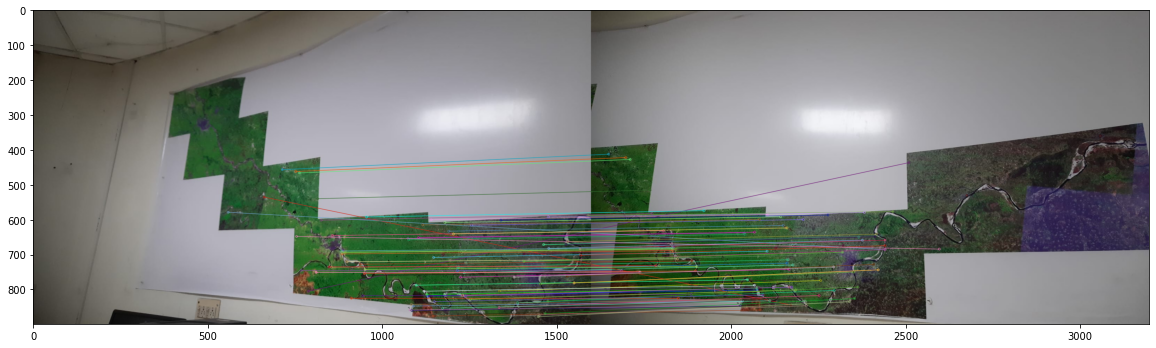

In [33]:
feature_to_match = "knn"

print("Drawing: {} matched features for ", feature_to_match)

fig = plt.figure(figsize = (20,8))

if feature_to_match == 'bf': 
  matches = Key_points_matching(Feature_train_img, Feature_query_img, method = feature_extraction_algo)
  mapped_feature_image = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


# Now for cross checking draw the feature-mapping lines also with KNN
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(Feature_train_img, Feature_query_img, ratio=0.75, method=feature_extraction_algo)
    
    mapped_features_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_features_image_knn)

In [36]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh): 
  #Converting keypoints to numpy array 
  keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
  keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])

  ''' For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4 '''
  if len(matches) > 4: 
    #Constructing two sets of points 
    points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
    points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
    
    #calculate the homography between the set of points 
    (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)
    return (matches, H, status) 
  else: 
    return None

In [37]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.87537557e+00 -1.74590033e-01 -1.18195387e+03]
 [ 3.76348925e-01  1.64019038e+00 -4.29561372e+02]
 [ 6.18462179e-04 -3.48183131e-05  1.00000000e+00]]


width  3198


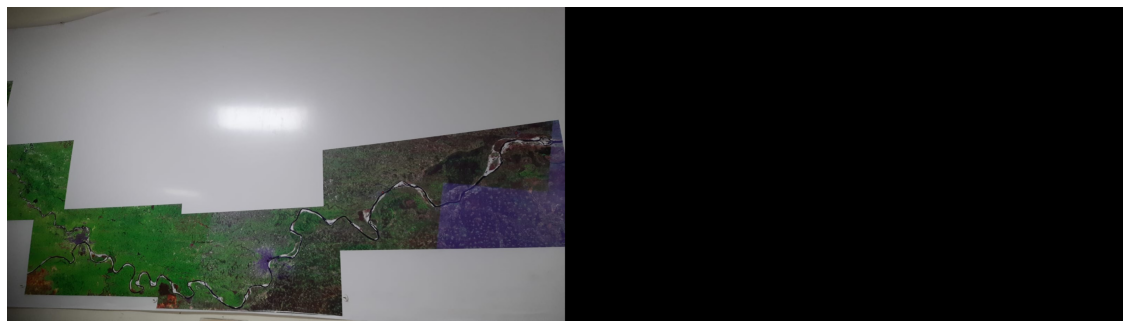

In [38]:
# For the calculation of the width and height of the final horizontal panoramic images 
# I can just add the widths of the individual images and for the height
# I can take the max from the 2 individual images.

width = query_photo.shape[1] + train_photo.shape[1]
print("width ", width) 
# 2922 - Which is exactly the sum value of the width of 
# my train.jpg and query.jpg


height = max(query_photo.shape[0], train_photo.shape[0])

# otherwise, apply a perspective warp to stitch the images together

# Now just plug that "Homography_Matrix"  into cv::warpedPerspective and I shall have a warped image1 into image2 frame

result = cv2.warpPerspective(train_photo, Homography_Matrix,  (width, height))

# The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my query_photo

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

imageio.imwrite("./output/horizontal_panorama_img_"+'.jpeg', result)

plt.show()
